# Resnet feature extractor and UMAP plotting

In [1]:
import numpy as np
import random as rand
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.applications import ResNet50
from cellx.tools.projection import ManifoldProjection2D as MyManifoldProjection2D
import tifffile as tiff
import glob
import os
from tqdm.notebook import tnrange, tqdm, tqdm_notebook
from skimage.transform import resize
from datetime import datetime
import time
import itertools

In [2]:
from cellx.manifold import projection

Define function to normalise images for resnet inference

In [3]:
def normalize_image_array(img):
    img_mean = np.mean(img)
    img_stddev = max(np.std(img), 1.0/np.size(img))
    img = np.subtract(img, img_mean)
    img = np.divide(img, img_stddev)
    # clip to 4 standard deviations
    img = np.clip(img, -4, 4)
    return img

## Define Resnet
Shape of Resnet input and load model

In [4]:
# resnet input: needs 3 channels
INPUT_SHAPE = (32, 32, 3)
# get pre-trained resnet
model = ResNet50(
    include_top=False, # exclude final fully-connected layer
    weights="imagenet",
    input_shape=INPUT_SHAPE,)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Set path to images
Find images and define N, the number of individual images you wish to load

In [29]:
files = glob.glob('/media/nathan/Transcend/Nathan/data/kraken/glimpses/kraken/pcna/MK0000/non_edge_masked_central_crop/*.tif')#'/home/nathan/data/kraken/pcna/local_glimpses/all/*.tif')
stack, flat_stack = [], []
N = int(len(files)/10)
print('Number of images:', N)

Number of images: 9030


## Load images
Dependent on computer but flash storage on my laptop can load a (175,000, 32, 32) stack in approx. 3.5 minutes

In [30]:
for i, file in tqdm_notebook(enumerate(files), total = N):
    if i < N:
        tif = np.array(tiff.imread(file),dtype=np.uint8)
        tif = resize(tif, (32,32))
        stack.append(tif)
imgs = np.stack(stack, axis = 0)
#flat_imgs = np.stack(flat_stack, axis = 0)
imgs.shape#, flat_imgs.shape
## getting rid of stack to save memory?
stack = []

#### Display a small subsection of images
To check that data has loaded

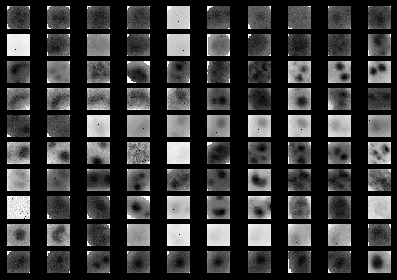

In [31]:
fig, ax_array = plt.subplots(10, 10)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(imgs[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

## Transform images
From single-channel to 3-channel for Resnet and UMAP

In [32]:
imgs = np.repeat(imgs[..., np.newaxis], 3, axis=-1)
imgs.shape

(9030, 32, 32, 3)

## Generate labels
Obtain precise and coarse data labels from the filename of each image which is labelled with fractional age of cell 

In [33]:
labels, coarse_labels = [], []
for j, i in enumerate(files):
  if j < N:
    label = float((i.split('age')[1]).split('.tif')[0]) 
    labels.append(label)
    if label < 0.34:
      coarse_label = 0
    elif label <0.67:
      coarse_label = 0.5
    else:
      coarse_label = 1
    coarse_labels.append(coarse_label)
print(labels)

[0.321, 0.398, 0.533, 0.562, 0.035, 0.171, 0.462, 0.584, 0.893, 0.083, 0.199, 0.32, 0.41, 0.431, 0.52, 0.631, 0.773, 0.794, 0.848, 0.149, 0.244, 0.496, 0.623, 0.889, 0.041, 0.048, 0.909, 0.032, 0.225, 0.347, 0.197, 0.202, 0.307, 0.342, 0.731, 0.384, 0.408, 0.796, 0.742, 0.219, 0.431, 0.982, 0.542, 0.563, 0.209, 0.349, 0.367, 0.372, 0.408, 0.426, 0.699, 0.842, 0.974, 0.154, 0.799, 0.008, 0.247, 0.414, 0.602, 0.841, 0.165, 0.306, 0.893, 0.037, 0.69, 0.364, 0.246, 0.586, 0.588, 0.698, 0.04, 0.457, 0.564, 0.239, 0.37, 0.836, 0.954, 0.604, 0.66, 0.285, 0.759, 0.991, 0.32, 0.656, 0.451, 0.569, 0.587, 0.934, 0.941, 0.004, 0.496, 0.85, 0.345, 0.859, 0.9, 0.927, 0.978, 0.591, 0.843, 0.06, 0.119, 0.189, 0.772, 0.968, 0.006, 0.127, 0.503, 0.86, 0.294, 0.629, 0.1, 0.155, 0.291, 0.398, 0.478, 0.58, 0.345, 0.503, 0.789, 0.175, 0.304, 0.927, 0.045, 0.692, 0.892, 0.965, 0.049, 0.109, 0.34, 0.396, 0.47, 0.818, 0.881, 0.073, 0.917, 0.031, 0.14, 0.308, 0.594, 0.014, 0.07, 0.42, 0.444, 0.927, 0.032, 0.057

## Normalisation: is this necessary? Memory bottleneck causes laptop to crash
Normalise images and covert to float32 for Resnet

In [34]:
imgs[0].dtype

dtype('float64')

In [35]:
imgs = normalize_image_array(imgs.astype(np.float32))
imgs.shape, imgs.dtype

((9030, 32, 32, 3), dtype('float32'))

## Extract features with trained resnet

In [36]:
test_features = model.predict(imgs, batch_size=64)
test_features.shape

(9030, 1, 1, 2048)

## Preprocessing for dimensionality reduction

In [37]:
# reshape model predictions to 2D array
X = test_features.reshape(test_features.shape[0], -1)
print(X.shape)
# standard scaling
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)

(9030, 2048)


# Define hyperparameters for UMAP
`nbs` = nearest neighbours

`eps` = epochs

In [38]:
nbs = 50
eps = 2000
rnd = 0

## Run UMAP 

In [39]:
mapper = UMAP(n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
mapper.fit(X)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=2000,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Wed Jul 28 15:03:39 2021 Finding Nearest Neighbors
Wed Jul 28 15:03:39 2021 Building RP forest with 10 trees
Wed Jul 28 15:03:40 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Wed Jul 28 15:03:50 2021 Finished Nearest Neighbor Search
Wed Jul 28 15:03:51 2021 Construct embedding
	completed  0  /  2000 epochs
	completed  200  /  2

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=2000,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)

## Plot mapper embedding

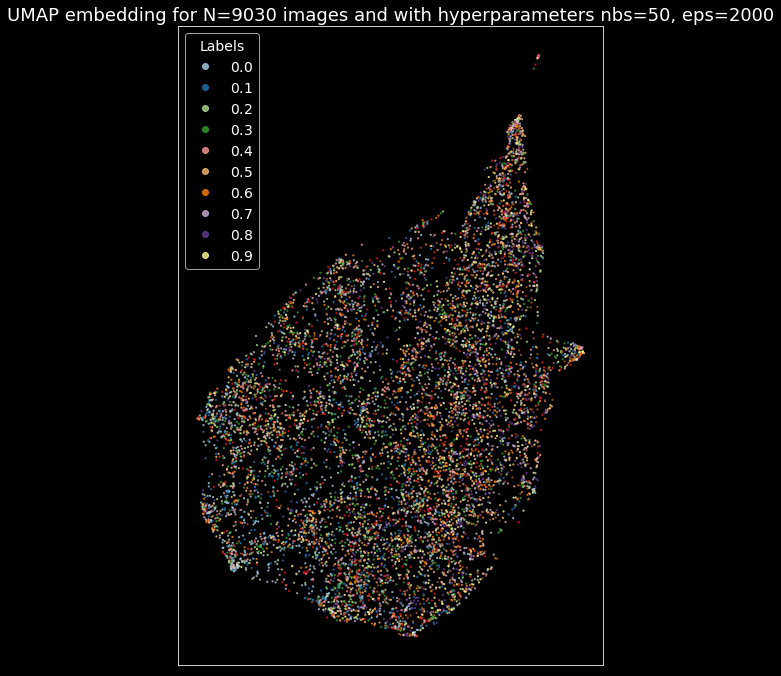

In [40]:
fig, ax = plt.subplots(figsize=(9.5, 9.5))
scatter = ax.scatter(mapper.embedding_[:, 1], 
                     mapper.embedding_[:, 0], 
                     c=labels, 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=5, zorder=1)

ax.set_title("UMAP embedding for N={} images and with hyperparameters nbs={}, eps={}".format(N,nbs,eps), fontsize=18)
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# fig.savefig(f"/content/drive/MyDrive/PhD/export_data/umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

## Plot manifold projection of images onto UMAP

In [1]:
bins = 32
embed_imgs = ((imgs-np.min(imgs))/(np.ptp(imgs)) * 255).astype(np.uint8)
mapper_projection = MyManifoldProjection2D(embed_imgs, output_shape=(32,32))
img_grid, heatmap, delimiters = mapper_projection(mapper.embedding_, components=(0,1), bins=bins, method='first')## method='sum'

NameError: name 'imgs' is not defined

In [42]:
mapper_projection.extent

(0.7844665050506592,
 15.166886329650879,
 -7.922682762145996,
 -0.30729129910469055)

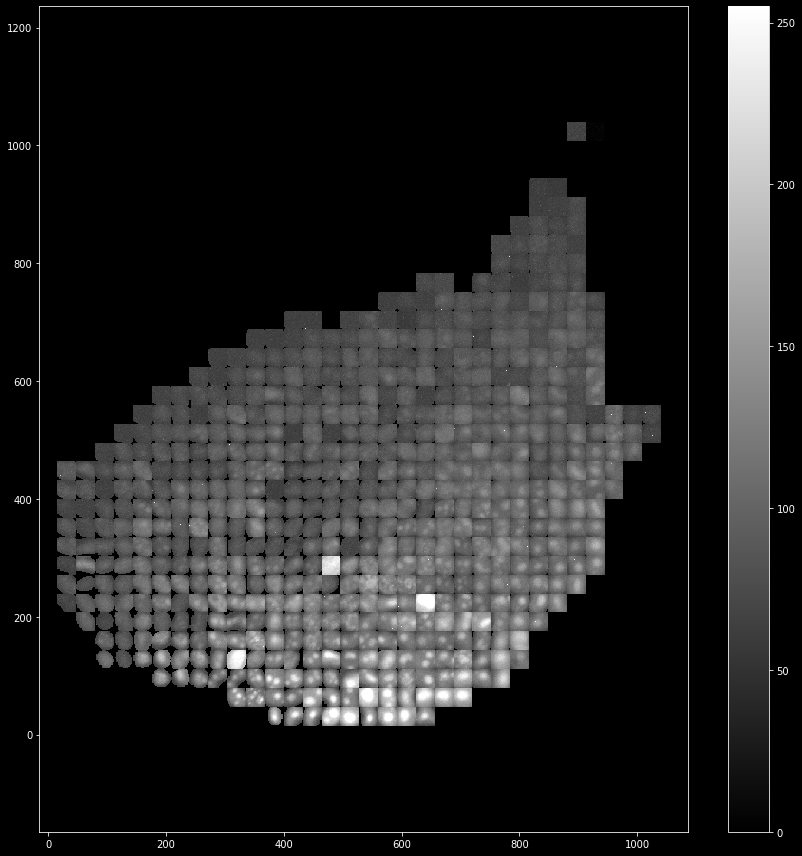

In [43]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12,12))
im = plt.imshow(img_grid,
                origin="lower",
                #extent=delimiters, 
                vmin=0, vmax=255, # modify or comment out according to image intensity values to show
                cmap="gray",)
plt.axis("equal")
plt.tight_layout()
plt.colorbar()

# Iterating over all of the above with different hyperparameters
The following functions take the previously loaded imagery and put it through the UMAP pipeline to test on different settings

In [17]:
def create_UMAP_projection(nbs, eps, save_out):
    rnd = 0
    mapper = UMAP(n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
    mapper.fit(X)
    # plot mapper embedding
    fig, ax = plt.subplots(figsize=(9.5, 9.5))

    scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=labels, 
                        #  label=["non-db", "db"], 
                         cmap="Paired", 
                         alpha=0.8, 
                         edgecolors="none", s=5, zorder=1)

    ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
    ax.set_facecolor('k')
    ax.set_axisbelow(True)
    ax.grid(color="0.25", linestyle="--")

    plt.tight_layout()
    #plt.show()
    if save_out == True:
        fn = '/home/nathan/data/kraken/pcna/UMAP/trial_output/UMAP_nbs{}_eps{}_{}.png'.format(nbs, eps, time.strftime("%Y%m%d-%H%M%S"))
        fig.savefig(fn, dpi=300, bbox_inches="tight")
    plt.clf()
    
    embed_imgs = ((imgs-np.min(imgs))/(np.ptp(imgs)) * 255).astype(np.uint8)
    mapper_projection = MyManifoldProjection2D(embed_imgs, output_shape=(32,32))
    img_grid, heatmap, delimiters = mapper_projection(mapper.embedding_, components=(0,1), bins=32)
    plt.style.use('dark_background')

    fig, ax = plt.subplots(figsize=(12,12))
    im = plt.imshow(img_grid,
                    origin="lower",
                    extent=delimiters, 
                    vmin=0, vmax=255, # modify or comment out according to image intensity values to show
                    cmap="gray",)
    plt.axis("off")
    plt.tight_layout()
    plt.colorbar()
    
    if save_out == True:
        fn = '/home/nathan/data/kraken/pcna/UMAP/trial_output/manifold_projection_nbs{}_eps{}_{}.png'.format(nbs, eps, time.strftime("%Y%m%d-%H%M%S"))
        plt.savefig(fn, dpi=300, bbox_inches="tight")
    plt.clf()

## Set hyperparameters and iterate through, creating and saving out different UMAP representations

In [ ]:
nbss = [5, 20, 50, 100]
epss = [800, 2000, 4000, 8000]
for nbs, eps in tqdm(itertools.product(nbss, epss)):
    create_UMAP_projection(nbs, eps, True)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=800,
     n_neighbors=5, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:19:15 2021 Finding Nearest Neighbors
Tue Jul 27 23:19:15 2021 Building RP forest with 12 trees
Tue Jul 27 23:19:17 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
Tue Jul 27 23:19:18 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:19:19 2021 Construct embeddin

100%|██████████| 262/262 [00:00<00:00, 4114.68it/s]


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=2000,
     n_neighbors=5, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:19:42 2021 Finding Nearest Neighbors
Tue Jul 27 23:19:42 2021 Building RP forest with 12 trees
Tue Jul 27 23:19:44 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
Tue Jul 27 23:19:45 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:19:45 2021 Construct embeddi

100%|██████████| 195/195 [00:00<00:00, 2829.37it/s]


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=4000,
     n_neighbors=5, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:20:33 2021 Finding Nearest Neighbors
Tue Jul 27 23:20:33 2021 Building RP forest with 12 trees
Tue Jul 27 23:20:35 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
Tue Jul 27 23:20:36 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:20:36 2021 Construct embeddi

100%|██████████| 165/165 [00:00<00:00, 2810.56it/s]


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=8000,
     n_neighbors=5, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:22:15 2021 Finding Nearest Neighbors
Tue Jul 27 23:22:15 2021 Building RP forest with 12 trees
Tue Jul 27 23:22:17 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
Tue Jul 27 23:22:18 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:22:18 2021 Construct embeddi

100%|██████████| 151/151 [00:00<00:00, 2548.59it/s]


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=800,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:25:18 2021 Finding Nearest Neighbors
Tue Jul 27 23:25:18 2021 Building RP forest with 12 trees
Tue Jul 27 23:25:20 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
Tue Jul 27 23:25:24 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:25:24 2021 Construct embedding
	completed  0  /  8

100%|██████████| 371/371 [00:00<00:00, 5608.77it/s]


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=2000,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:26:11 2021 Finding Nearest Neighbors
Tue Jul 27 23:26:11 2021 Building RP forest with 12 trees
Tue Jul 27 23:26:13 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
Tue Jul 27 23:26:17 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:26:17 2021 Construct embedding
	completed  0  /  

100%|██████████| 415/415 [00:00<00:00, 6197.10it/s]


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=4000,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:27:51 2021 Finding Nearest Neighbors
Tue Jul 27 23:27:51 2021 Building RP forest with 12 trees
Tue Jul 27 23:27:53 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
Tue Jul 27 23:27:56 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:27:57 2021 Construct embedding
	completed  0  /  

100%|██████████| 335/335 [00:00<00:00, 5001.06it/s]


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=8000,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:31:06 2021 Finding Nearest Neighbors
Tue Jul 27 23:31:06 2021 Building RP forest with 12 trees
Tue Jul 27 23:31:07 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
Tue Jul 27 23:31:11 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:31:11 2021 Construct embedding
	completed  0  /  

100%|██████████| 372/372 [00:00<00:00, 5759.15it/s]


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=800,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:37:22 2021 Finding Nearest Neighbors
Tue Jul 27 23:37:22 2021 Building RP forest with 12 trees
Tue Jul 27 23:37:24 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
Tue Jul 27 23:37:35 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:37:36 2021 Construct embedding
	completed  0  /  800 epochs
	completed  

100%|██████████| 457/457 [00:00<00:00, 6734.70it/s]


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=2000,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:38:29 2021 Finding Nearest Neighbors
Tue Jul 27 23:38:29 2021 Building RP forest with 12 trees
Tue Jul 27 23:38:30 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
Tue Jul 27 23:38:42 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:38:43 2021 Construct embedding
	completed  0  /  2000 epochs
	completed

100%|██████████| 454/454 [00:00<00:00, 6244.47it/s]


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=4000,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:40:56 2021 Finding Nearest Neighbors
Tue Jul 27 23:40:56 2021 Building RP forest with 12 trees
Tue Jul 27 23:40:58 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
Tue Jul 27 23:41:10 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:41:10 2021 Construct embedding
	completed  0  /  4000 epochs
	completed

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
100%|██████████| 372/372 [00:00<00:00, 6027.23it/s]
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=8000,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:45:22 2021 Finding Nearest Neighbors
Tue Jul 27 23:45:22 2021 Building RP forest with 12 trees
Tue Jul 27 23:45:24 2021 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
Tue Jul 27 23:45:35 2021 Finished Nearest Neighbor Search
Tue Jul 27 23:45:36 2021 Construct embedding
	completed  0  /  8000 epochs
	completed

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
100%|██████████| 466/466 [00:00<00:00, 6704.69it/s]
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=800,
     n_neighbors=100, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 27 23:54:09 2021 Finding Nearest Neighbors
Tue Jul 27 23:54:09 2021 Building RP forest with 12 trees


# Appendix (rest of Laure's code)

In [ ]:
# define densmap instance (takes in a local density parameter) with above hyperparameters
dens_mapper = UMAP(densmap=True, n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
dens_mapper.fit(X)

In [ ]:
# plot densmapper embedding
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(dens_mapper.embedding_[:, 1], dens_mapper.embedding_[:, 0], c=test_labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=5, zorder=1)

# ax.set_title("UMAP embedding", fontsize=18)
# ax.legend()
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

# plt.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# fig.savefig(f"{export_path}umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

**superimposing binned images on embedding (like a 2D histogram)**
- in the `MyManifoldProjection` function, you can choose between showing an average image of the bin or showing a single image

In [51]:
def create_manifold_projection(bins):
    embed_imgs = ((imgs-np.min(imgs))/(np.ptp(imgs)) * 255).astype(np.uint8)
    mapper_projection = MyManifoldProjection2D(embed_imgs, output_shape=(32,32))
    img_grid, heatmap, delimiters = mapper_projection(mapper.embedding_, components=(0,1), bins=bins)
    plt.style.use('dark_background')

    fig, ax = plt.subplots(figsize=(12,12))
    im = plt.imshow(img_grid,
                    origin="lower",
                    extent=delimiters, 
                    vmin=0, vmax=255, # modify or comment out according to image intensity values to show
                    cmap="gray",)
    plt.axis("off")
    plt.tight_layout()
    plt.colorbar()
    
    fn = 'UMAP_attempt_{}.png'.format(time.strftime("%Y%m%d-%H%M%S"))
    plt.savefig(fn, dpi=300, bbox_inches="tight")

In [36]:
# normalize image values to 0-1 range (Min-Max scaling) & 
# convert to 8-bit for projection on umap
embed_imgs = ((imgs-np.min(imgs))/(np.ptp(imgs)) * 255).astype(np.uint8)
print(embed_imgs.shape)

(6689, 32, 32, 3)


In [37]:
# define ManifoldProjection instance with specified output shape (default = 64x64)
mapper_projection = MyManifoldProjection2D(embed_imgs, output_shape=(32,32))

In [45]:
# get image grid, increase bin number to show more images/granularity
img_grid, heatmap, delimiters = mapper_projection(mapper.embedding_, components=(0,1), bins=64)
#img_grid_dens, heatmap_dens, delimiters_dens = mapper_projection(dens_mapper.embedding_, components=(0,1), bins=16)


100%|██████████| 1649/1649 [00:00<00:00, 22594.81it/s]


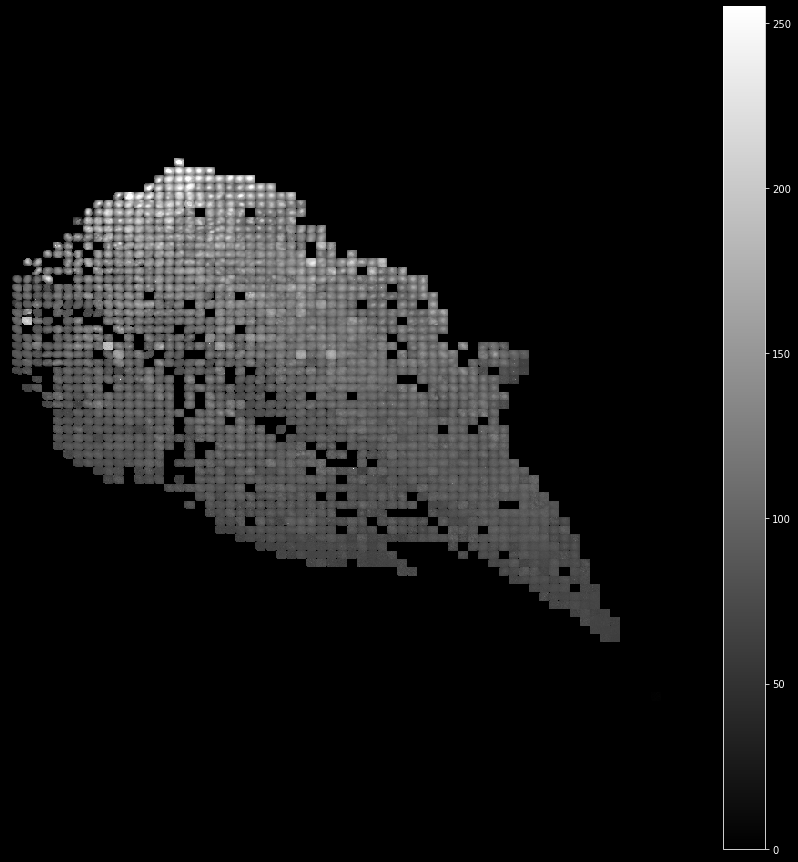

In [49]:
# plot mapper image projection

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12,12))

im = plt.imshow(img_grid,
                origin="lower",
                extent=delimiters, 
                vmin=0, vmax=255, # modify or comment out according to image intensity values to show
                cmap="gray",)

# scatter plot will only show appropriately if `extent` is used in imshow
# scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=test_labels, 
#                     #  label=["non-db", "db"], 
#                      cmap="Paired", 
#                     #  alpha=0.3, 
#                      edgecolors="none", 
#                      s=3, 
#                      zorder=2)

plt.axis("off")
plt.tight_layout()
plt.colorbar()
plt.savefig('UMAP_attempt.png', dpi=300, bbox_inches="tight")
#fig.savefig('/content/drive/MyDrive/phd/colab_data/UMAP_attempt.png', dpi=300, bbox_inches="tight")

In [ ]:
# plot densmapper image projection

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 9.5))

im = plt.imshow(img_grid_dens,
                origin="lower",
                # extent=delimiters, 
                vmin=100, vmax=140, # modify or comment out according to image intensities
                cmap="gray",)

# scatter plot will only show appropriately if `extent` is used in imshow
# scatter = ax.scatter(mapper_dens.embedding_[:, 1], mapper_dens.embedding_[:, 0], c=test_labels, 
#                     #  label=["non-db", "db"], 
#                      cmap="Paired", 
#                     #  alpha=0.3, 
#                      edgecolors="none", 
#                      s=3, 
#                      zorder=2)

plt.axis("off")
plt.tight_layout()
plt.colorbar()

# fig.savefig(f"{output_path}umap_dens_masked_32bins_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

In [ ]:
# # personalized
# from scipy.stats import binned_statistic_2d
# from skimage.io import imread
# from skimage.transform import resize
# from tqdm import tqdm

# def _load_and_normalize(filename: str, output_shape: tuple = (64, 64)):
#     """Load an image, reshape to output_shape and normalize."""

#     # reshape to a certain image size
#     image = resize(imread(filename), output_shape, preserve_range=True)
#     n_pixels = np.prod(output_shape)
#     n_channels = image.shape[-1]
#     print(f"channels: {n_channels}")

#     a_std = lambda d: np.max([np.std(d), 1.0 / np.sqrt(n_pixels)])
#     nrm = lambda d: np.clip((d - np.mean(d)) / a_std(d), -4.0, 4.0)

#     for dim in range(n_channels):
#         image[..., dim] = nrm(image[..., dim])

#     # TODO(arl): ????
#     image = np.clip(255.0 * ((image + 1.0) / 5.0), 0, 255)
#     return image

# """
# class MyManifoldProjection2D:
#     """ManifoldProjection2D.

#     Make a montage of image patches that represent examples from a manifold
#     projection.

#     Parameters
#     ----------
#     images : list of str or (N, W, H, C) np.ndarray
#         A list of image filenames or a numpy array of N images, width W, height
#         H, and C channels.
#     output_shape : tuple of int
#         Final size to reshape individual image patches to for the montage.
#     preload_images : bool
#         Preload images if a list of image filenames is provided, or not.
#     """

#     def __init__(
#         self, images: list, output_shape: tuple = (64, 64), preload_images: bool = True,
#     ):

#         self._output_shape = output_shape
#         self._images = None

#         # check if `images` parameter is a list of strings or a numpy array
#         # to preload images, or not
#         if all([isinstance(img, str) for img in images]):
#             if preload_images:
#                 self._images = [self._get_image(file) for file in tqdm(images)]
#         else:
#             if not isinstance(images, np.ndarray):
#                 raise ValueError("Image type unknown.")
#             self._images = images

#     def _get_image(self, filename: str) -> np.ndarray:
#         """Grab an image and resize it."""
#         return _load_and_normalize(filename, output_shape=self._output_shape)

#     def __call__(
#         self, manifold: np.ndarray, bins: int = 32, components: tuple = (0, 1)
#     ) -> tuple:
#         """Build the projection.

#         Parameters
#         ----------
#         manifold : np.ndarray
#             Numpy array of the manifold projection.
#         bins : int
#             Number of two-dimensional bins to group the manifold examples in.
#         components : tuple of int
#             Dimensions of manifold to use when creating the projection.

#         Returns
#         -------
#         imgrid : np.ndarray
#             An image with example image patches from the manifold arranged on a
#             grid.
#         extent : tuple
#             Delimits the minimum and maximum bin edges, in each dimension, used
#             to create the result.
#         """

#         assert manifold.shape[0] == len(self._images)

#         # bin the manifold
#         counts, xe, ye, bn = binned_statistic_2d(
#             manifold[:, components[0]],
#             manifold[:, components[1]],
#             [],
#             bins=bins,
#             statistic="count",
#             expand_binnumbers=True,
#         )

#         bxy = zip(bn[0, :].tolist(), bn[1, :].tolist())

#         # make a lookup dictionary
#         grid = {}
#         for idx, b in enumerate(bxy):
#             if b not in grid:
#                 grid[b] = []

#             if self._images is not None:
#                 grid[b].append(self._images[idx])
#             else:
#                 if not grid[b]:
#                     grid[b].append(self._get_image(self._image_files[idx]))

#         # now make the grid image
#         full_bins = [int(b) for b in self._output_shape]
#         half_bins = [b // 2 for b in self._output_shape]
#         imgrid = np.zeros(
#             (
#                 (full_bins[0] + 1) * bins + half_bins[0],
#                 (full_bins[1] + 1) * bins + half_bins[1],
#                 3,
#             ),
#             dtype="uint16",
#         )
#         # build it
#         for e, (xy, images) in enumerate(tqdm(grid.items())):
#             stack = np.stack(images, axis=0)
#             # get average of each stack of images -> average image generated
#             # im = np.mean(stack, axis=0)
#             # get random single image from stack
#             rand.seed(e)
#             rnd_pos = rand.randint(0, len(stack)-1)
#             im = stack[rnd_pos, ...]

#             xx, yy = xy
#             blockx = slice(
#                 xx * full_bins[0] - half_bins[0],
#                 xx * full_bins[0] - half_bins[0] + self._output_shape[0],
#                 1,
#             )
#             blocky = slice(
#                 yy * full_bins[1] - half_bins[1],
#                 yy * full_bins[1] - half_bins[1] + self._output_shape[1],
#                 1,
#             )

#             try:
#                 imgrid[blockx, blocky] = im
#             except:
#                 raise ValueError("`imgrid` error")
#                 pass
            
#         # switch `xe` and `ye` around to get the right xy axes on the projection 
#         extent = (min(ye), max(ye), min(xe), max(xe))
#         print(extent)

#         return imgrid, counts, extent
# """